In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import xarray as xr
import glob
from scipy.stats import skew

In [2]:
path="/lustre/ytzheng/"
Casename = 'ASTEX_cold2.6'
Casename1 = 'ASTEX_warm2.6'

f = xr.open_mfdataset(path + Casename + '/' +  '*000.nc',
                      combine = 'by_coords',decode_cf = False)

f1 = xr.open_mfdataset(path + Casename1 + '/' + '*000.nc',
                      combine = 'by_coords',decode_cf = False)

In [3]:
f = f.isel(z = slice(0, 400))
f1 = f1.isel(z = slice(0, 400))
ind_time = 31

In [5]:
#get the cloud base height
with xr.open_mfdataset(path + Casename + '/' +  'postproc_out_N100.nc',
                      combine = 'by_coords',decode_cf = False) as ff:
    zcb = ff['zcb'].values[ind_time]

with xr.open_mfdataset(path + Casename1 + '/' +  'postprocessed_N100.nc',
                      combine = 'by_coords',decode_cf = False) as ff:
    zcb1 = ff['zcb'].values[ind_time]

In [6]:
f

<xarray.Dataset>
Dimensions:  (time: 1, x: 120, y: 120, z: 400)
Coordinates:
  * x        (x) float32 0.0 35.0 70.0 105.0 ... 4060.0 4095.0 4130.0 4165.0
  * y        (y) float32 0.0 35.0 70.0 105.0 ... 4060.0 4095.0 4130.0 4165.0
  * z        (z) float32 10.5 22.5 37.5 52.5 ... 2387.5 2392.5 2397.5 2402.5
  * time     (time) float32 166.25
Data variables:
    p        (z) float32 dask.array<chunksize=(400,), meta=np.ndarray>
    U        (time, z, y, x) float32 dask.array<chunksize=(1, 400, 120, 120), meta=np.ndarray>
    V        (time, z, y, x) float32 dask.array<chunksize=(1, 400, 120, 120), meta=np.ndarray>
    W        (time, z, y, x) float32 dask.array<chunksize=(1, 400, 120, 120), meta=np.ndarray>
    PP       (time, z, y, x) float32 dask.array<chunksize=(1, 400, 120, 120), meta=np.ndarray>
    QRAD     (time, z, y, x) float32 dask.array<chunksize=(1, 400, 120, 120), meta=np.ndarray>
    TABS     (time, z, y, x) float32 dask.array<chunksize=(1, 400, 120, 120), meta=np.ndarray>


In [7]:
QTOT = f['QN'] + f['QV']
QTOT1 = f1['QN'] + f1['QV']

In [8]:
z = f['z']
x = f['x']/1000.
y = f['y']/1000.
time = f['time']

In [16]:
def plt2D_domain(fig, ax, x, y, var, var1, 
                 ztitle, 
                 mycmap=cm.coolwarm,
                 mylevels=[0.], extend = 'neigther',
                 z1plt = 1,
                doreturn = 0):
    
    if len(mylevels) == 1:
        oax = ax.contourf(x,y,var, cmap = mycmap, extend = extend)
    else:
        oax = ax.contourf(x,y,var, cmap = mycmap, levels = mylevels, extend = extend)
    
    if z1plt == 1:
        ax.contour(x,y,var1, colors = 'black', 
                   levels = [var1.load().quantile(0.9, dim = ('x', 'y')).values], 
                   linewidths = 0.5)
        
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    
#     cbar = fig.colorbar(oax, ax = ax, orientation='vertical', shrink=0.8)
#     cbar.set_label(ztitle, fontsize=myfontsize)
    
#     ax.set_xlabel('x (km)', fontsize=myfontsize) 
#     ax.set_ylabel('y (km)', fontsize=myfontsize) 

    if doreturn == 1:
        return oax

In [10]:
def pltwhist(ax, var, var1, ytitle = ''):
    myhistrange = (-2,2)
    ax.hist(var, 30, density=True, range = myhistrange, alpha=0.3, label = 'CADV \nskew.=%.1f' % skew(var))
    ax.hist(var1, 30, density=True, range = myhistrange, alpha=0.3, label = 'WADV \nskew.=%.1f' % skew(var1))
    
    ax.set_xlabel('w (m/s)')
    ax.set_ylabel(ytitle)
    
    ax.set_yscale('log')
    ax.yaxis.set_tick_params(labelsize=6)
    ax.legend(fontsize = 6, loc = 'upper left')

In [11]:
myfontsize = 12

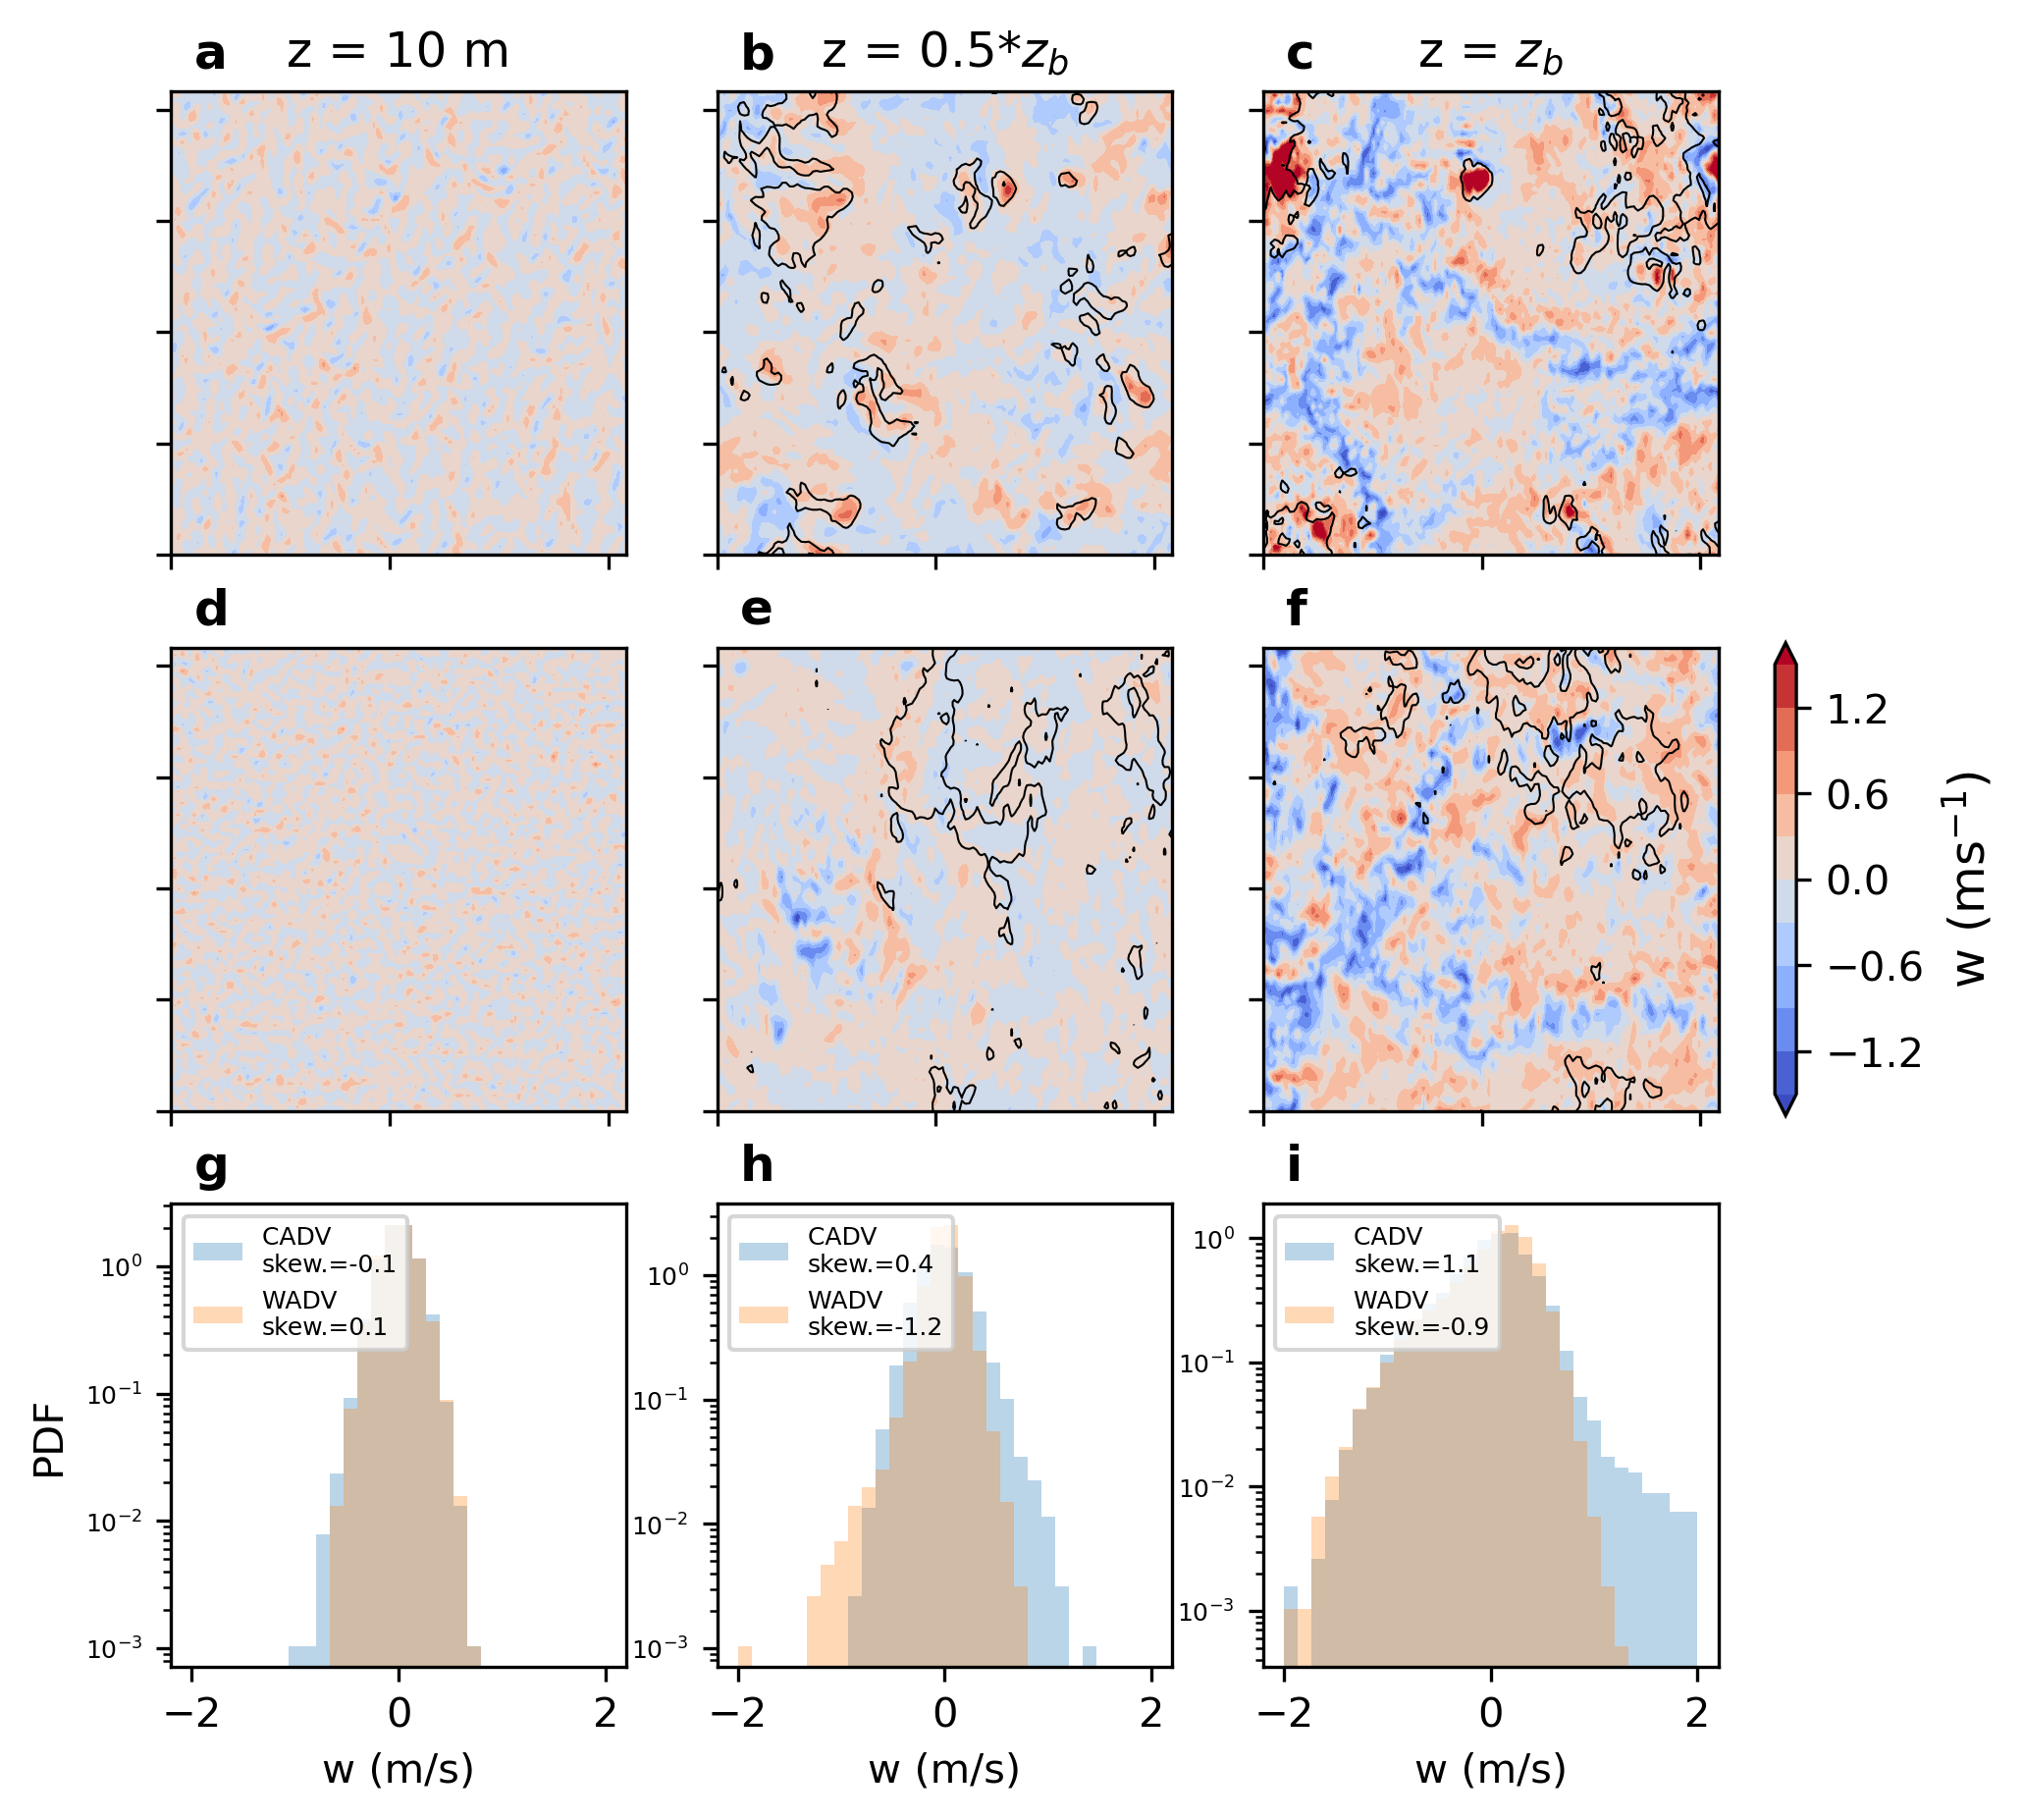

In [24]:
fig, axs = plt.subplots(ncols = 3,
                        nrows = 3,
#                         sharex = True, sharey = True,
                        figsize=(21/2.54, (18)/2.54), dpi = 300)

mylevels = np.linspace(-1.5, 1.5, 10 + 1)

plt2D_domain(fig, axs[0,0], x, y, f['W'].sel(z = z[1], method="nearest").isel(time=0),
             QTOT.sel(z = z[1], method="nearest").isel(time=0), 'W',
             mylevels=mylevels, extend='both', z1plt = 0)

plt2D_domain(fig, axs[0,1], x, y, f['W'].sel(z = 0.5*zcb, method="nearest").isel(time=0),
             QTOT.sel(z = 0.5*zcb, method="nearest").isel(time=0), 'W',
             mylevels=mylevels, extend='both')

oax = plt2D_domain(fig, axs[0,2], x, y, f['W'].sel(z = zcb, method="nearest").isel(time=0),
             QTOT.sel(z = zcb, method="nearest").isel(time=0), 'W',
             mylevels=mylevels, extend='both', doreturn = 1)

plt2D_domain(fig, axs[1,0], x, y, f1['W'].sel(z = z[1], method="nearest").isel(time=0),
             QTOT1.sel(z = z[1], method="nearest").isel(time=0), 'W',
             mylevels=mylevels, extend='both', z1plt = 0)

plt2D_domain(fig, axs[1,1], x, y, f1['W'].sel(z = 0.5*zcb1, method="nearest").isel(time=0),
             QTOT1.sel(z = 0.5*zcb1, method="nearest").isel(time=0), 'W',
             mylevels=mylevels, extend='both')

plt2D_domain(fig, axs[1,2], x, y, f1['W'].sel(z = zcb1, method="nearest").isel(time=0),
             QTOT1.sel(z = zcb1, method="nearest").isel(time=0), 'W',
             mylevels=mylevels, extend='both')

cbar = fig.colorbar(oax,  ax=axs, orientation='vertical', pad=0.03, shrink = 0.3, extend='both')
cbar.set_label(r"$\mathrm{w \ (ms^{-1})}$", fontsize=myfontsize)

#plot histo
pltwhist(axs[2,0], f['W'].sel(z = z[1], method="nearest").isel(time=0).values.flatten(),
         f1['W'].sel(z = z[1], method="nearest").isel(time=0).values.flatten(), ytitle = 'PDF')

pltwhist(axs[2,1], f['W'].sel(z = 0.5*zcb, method="nearest").isel(time=0).values.flatten(),
         f1['W'].sel(z = 0.5*zcb1, method="nearest").isel(time=0).values.flatten())

pltwhist(axs[2,2], f['W'].sel(z = zcb, method="nearest").isel(time=0).values.flatten(),
         f1['W'].sel(z = zcb1, method="nearest").isel(time=0).values.flatten())

axs[0,0].title.set_text('z = 10 m')
axs[0,1].title.set_text('z = 0.5*$z_b$')
axs[0,2].title.set_text('z = $z_b$')


mylabel = np.array((['a','b','c'],['d','e','f'], ['g','h','i']))

for i in range(3):
    for j in range (3):
        axs[i,j].text(0.05, 1.05, mylabel[i,j], transform=axs[i,j].transAxes,fontsize=myfontsize, fontweight='bold')
        
fig.savefig('plot_result_2D_visualization.png', dpi=fig.dpi, bbox_inches='tight')